In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
games = pd.read_csv("../games_ml.csv")

In [40]:
games.dtypes

release_date                          float64
price                                 float64
early_access                            int64
genres_Accounting                       int64
genres_Action                           int64
                                       ...   
publisher_Wizards of the Coast LLC    float64
publisher_505 Games                   float64
publisher_Sekai Project               float64
publisher_AGM PLAYISM                 float64
publisher_Focus Home Interactive      float64
Length: 426, dtype: object

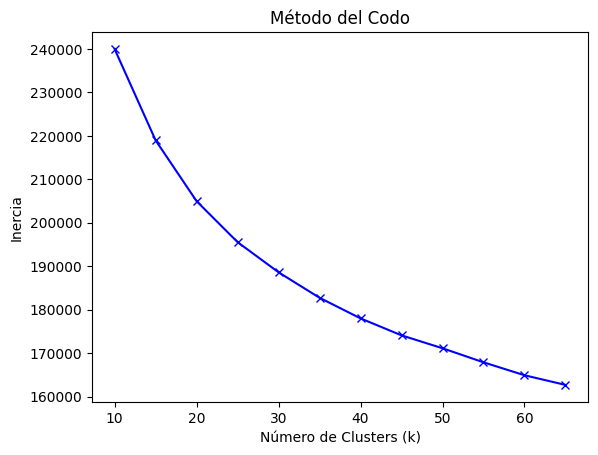

In [7]:
# Método del codo (Elbow Method)
# Consiste en calcular la inercia para distintas instancias del algoritmo de clustering,
# graficarlas y determinar el punto de inflexión más fuerte (codo). 
# Ese será el n de clusters más eficiente

n_clusters = range(10, 70, 5)
elbow_scores = []
silhouette_scores = []

for k in n_clusters:
    kmeans = KMeans(n_clusters = k, n_init = 10)
    kmeans.fit(np.array(games))
    elbow_scores.append(kmeans.inertia_)

# Graficar la suma de las distancias cuadradas intra-cluster (inertias) en función de k
plt.plot(n_clusters, elbow_scores, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

# Por el gráfico notamos el codo en k = 25 clusters

In [41]:
# Creamos las instancia de KMeans con el valor de cluster óptimo y hacemos las predicciones
kmeans = KMeans(n_clusters = 25, n_init = 10, random_state = 123)
kmeans.fit(games)
labels = kmeans.predict(games)

In [42]:
# Queremos ver la distribucion de valores en los clusters
valores_unicos, frecuencias = np.unique(labels, return_counts=True)

In [43]:
print(valores_unicos)
print(frecuencias)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[1239 1484 1619 1161 1980  303  661 1465 1774 1430   16  944 1186 2258
  850    3  549  265  898  939 1319 2257 3056 1752  677]


In [44]:
# Hay clusters con muy pocos elementos (uno con 3). Debemos fusionar con otro porque no nos sirve para el modelo de ML
min_elementos_por_cluster = 10  # Número mínimo de elementos por clúster

for cluster_id, count in zip(valores_unicos, frecuencias):
    if count < min_elementos_por_cluster:
        # Encuentra el clúster más cercano para fusionarlo
        centroid = kmeans.cluster_centers_[cluster_id]
        # Elimina el clúster actual de la lista de centroides
        centroides_sin_actual = np.delete(kmeans.cluster_centers_, cluster_id, axis=0)
        distancias_a_centroides = np.linalg.norm(centroides_sin_actual - centroid, axis=1)
        # Ajusta el índice del clúster a fusionar después de eliminar el actual
        cluster_a_fusionar = np.argmin(distancias_a_centroides)
        # Fusiona el clúster actual con el clúster más cercano
        labels[kmeans.labels_ == cluster_id] = cluster_a_fusionar

In [45]:
# Fusiono el cluster 15 con el 10
print(np.unique(labels, return_counts = True))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17,
       18, 19, 20, 21, 22, 23, 24]), array([1239, 1484, 1619, 1161, 1980,  303,  661, 1465, 1774, 1430,   19,
        944, 1186, 2258,  850,  549,  265,  898,  939, 1319, 2257, 3056,
       1752,  677], dtype=int64))


In [46]:
# Exportamos las predicciones para ser consumidas por el modelo de ML
# Convertimos el array de labels a texto y con los valores tipo entero
np.savetxt('../labels.csv', labels, delimiter = ',', fmt = '%d')  